<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#Parameters" data-toc-modified-id="Parameters-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Functions</a></span></li></ul></li><li><span><a href="#Minimal-encoding-of-time" data-toc-modified-id="Minimal-encoding-of-time-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Minimal encoding of time</a></span><ul class="toc-item"><li><span><a href="#An-example" data-toc-modified-id="An-example-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>An example</a></span></li><li><span><a href="#Systematic" data-toc-modified-id="Systematic-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Systematic</a></span></li></ul></li></ul></div>

# Preamble

In [3]:
import  pprint
import  subprocess 
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline

np.set_printoptions(suppress=True, precision=5)

from network import Protocol, NetworkManager, Network
from patterns_representation import PatternsRepresentation
from analysis_functions import calculate_persistence_time, calculate_recall_quantities, calculate_triad_connectivity
from plotting_functions import plot_weight_matrix, plot_network_activity_angle, plot_persistent_matrix

## Parameters

In [4]:
epsilon = 10e-80
vmin = -3.0
remove = 0.010

strict_maximum = True

dt = 0.001
tau_s = 0.010
tau_a = 0.250
g_I = 2.0
g_a = 2.0
G = 50.0

sns.set(font_scale=3.5)
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['figure.figsize'] = (12, 8)
lw = 10
ms = 22
alpha_graph = 0.3
colors = sns.color_palette()

## Functions

# Minimal encoding of time

## An example

pattern sequence [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8]
times [0.018000000000000002, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.028, 0.013000000000000001]
T_calculated 0.016444444444444442


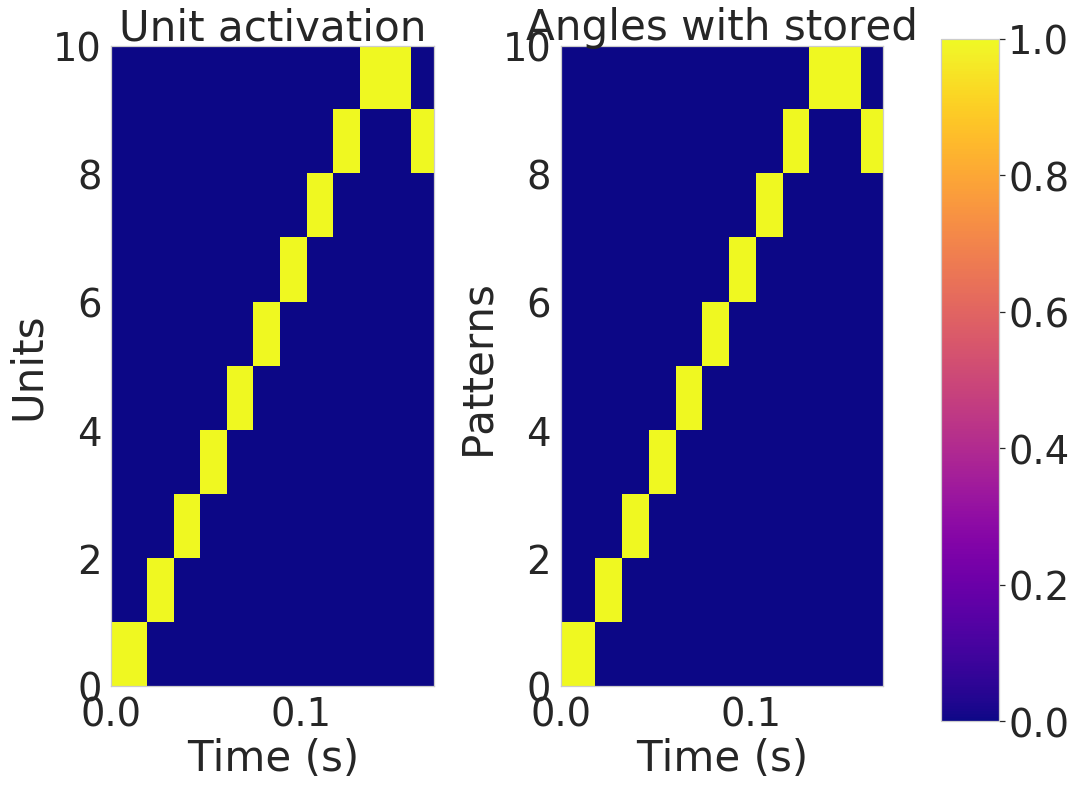

In [48]:
sigma_out = 0.0
tau_z_pre = 0.025
tau_z_post = 0.020


hypercolumns = 1
minicolumns = 10
n_patterns = minicolumns


# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.0
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 1.0
resting_time = 1.0
epochs = 1
T_persistence = 0.015

# Manager properties
values_to_save = ['o']


# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)


# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)
# Set the persistent time
manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence, from_state=1, to_state=2)

T_cue = 1.0 * manager.nn.tau_s
T_recall = T_persistence * n_patterns + T_cue

# Success
nr = representation.network_representation
aux = calculate_recall_quantities(manager, nr, T_recall, T_cue, remove=remove, reset=True, empty_history=True)
success, pattern_sequence, persistent_times, timings = aux

print('pattern sequence', pattern_sequence)
print('times', persistent_times)
print('T_calculated', np.mean(persistent_times[1:-1]))
plot_network_activity_angle(manager, time_y=False);

In [49]:
O = manager.history['o']

In [50]:
for o in O.T:
    print(o.shape)

(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)


In [35]:
def calculate_encoded_time(T_to_encode, tau_s, remove):
    sigma_out = 0.0
    tau_z_pre = 0.025
    tau_z_post = 0.020

    hypercolumns = 1
    minicolumns = 10
    n_patterns = minicolumns


    # Training protocol
    training_times_base = 0.100
    training_times = [training_times_base for i in range(n_patterns)]
    ipi_base = 0.0
    inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
    inter_sequence_interval = 1.0
    resting_time = 1.0
    epochs = 1
    T_persistence = T_to_encode

    # Manager properties
    values_to_save = ['o']


    # Neural Network
    nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                     tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                     strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    # Build the representation
    representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)


    # Build the protocol
    protocol = Protocol()
    protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                        inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

    # Run the protocol
    timed_input = manager.run_network_protocol_offline(protocol=protocol)
    # Set the persistent time
    manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence, from_state=1, to_state=2)

    T_cue = 1.0 * manager.nn.tau_s
    T_recall = T_persistence * n_patterns + T_cue

    nr = representation.network_representation
    # Success 1
    aux = calculate_recall_quantities(manager, nr, T_recall, T_cue, remove=remove, reset=True, empty_history=True)
    success, pattern_sequence, persistent_times, timings = aux

    T_encoded =  np.mean(persistent_times[1:-1])
    
    return T_encoded

## Systematic

In [66]:
min_T = 0.005
num_T = 10
remove = 0.004
tau_s_collection = [0.005, 0.010, 0.015]
T_encoded_collection = []
T_to_encode_vector = np.linspace(min_T, 0.080, num=num_T)

for tau_s in tau_s_collection:
    T_encoded_vector = np.zeros(num_T)
    for index_t, T_to_encode in enumerate(T_to_encode_vector):
        T_encoded = calculate_encoded_time(T_to_encode, tau_s, remove)
        T_encoded_vector[index_t] = T_encoded
    T_encoded_collection.append(np.copy(T_encoded_vector))

/home/heberto/miniconda/envs/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/heberto/miniconda/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


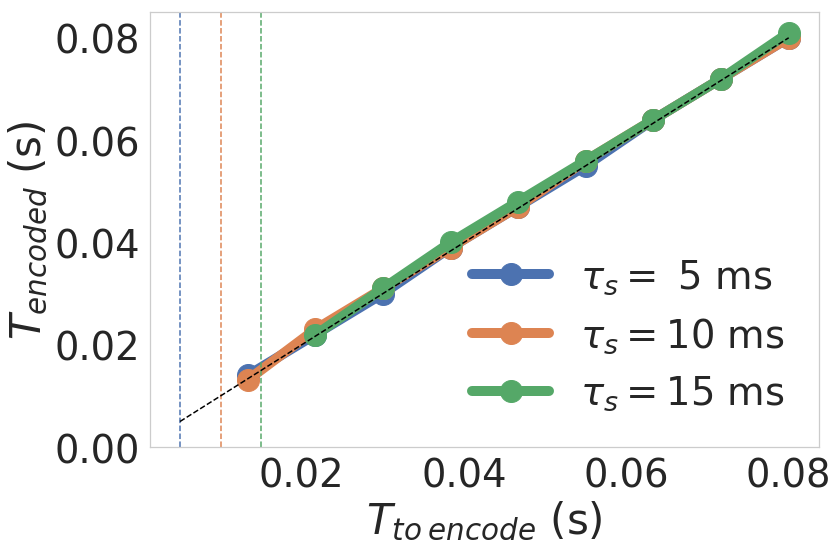

In [76]:
save = True

fig = plt.figure()
ax = fig.add_subplot(111)

for index, tau_s in enumerate(tau_s_collection):
    T_encoded_vector = T_encoded_collection[index]
    label = r'$\tau_s = $' + f'{1000 * tau_s:2.0f} ms'
    ax.plot(T_to_encode_vector, T_encoded_vector, 'o-', color=colors[index], ms=ms, lw=lw, 
            label=label)

    ax.axvline(tau_s, ls='--', color=colors[index])
    
ax.plot(T_to_encode_vector, T_to_encode_vector, '--', color='black')
ax.set_ylim([0.0, T_to_encode_vector[-1] + 0.005])
ax.legend(frameon=False)
ax.set_xlabel(r'$T_{to \: encode} $ (s)')
ax.set_ylabel(r'$T_{encoded}$ (s)')

if save:
    directory = '../plot_producers/'
    file_name = 'time_encoding' 
    format_string = '.pdf'
    string_to_save = directory + file_name + format_string
    fig.savefig(string_to_save, frameon=False, dpi=110, bbox_inches='tight')